In [1]:
import cupy as cp
from cupyx import scatter_add
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from includes.preprocessor import write_keywords,write_birth,write_parameters
from includes.gamma import domain_mgr, heat_solve_mgr,load_toolpath,get_toolpath
%matplotlib notebook
cp.cuda.Device(1).use()
!nvidia-smi

Mon Apr 26 12:58:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:01:00.0 Off |                  Off |
| 57%   78C    P2   258W / 260W |  29330MiB / 48598MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:21:00.0 Off |                  Off |
| 33%   

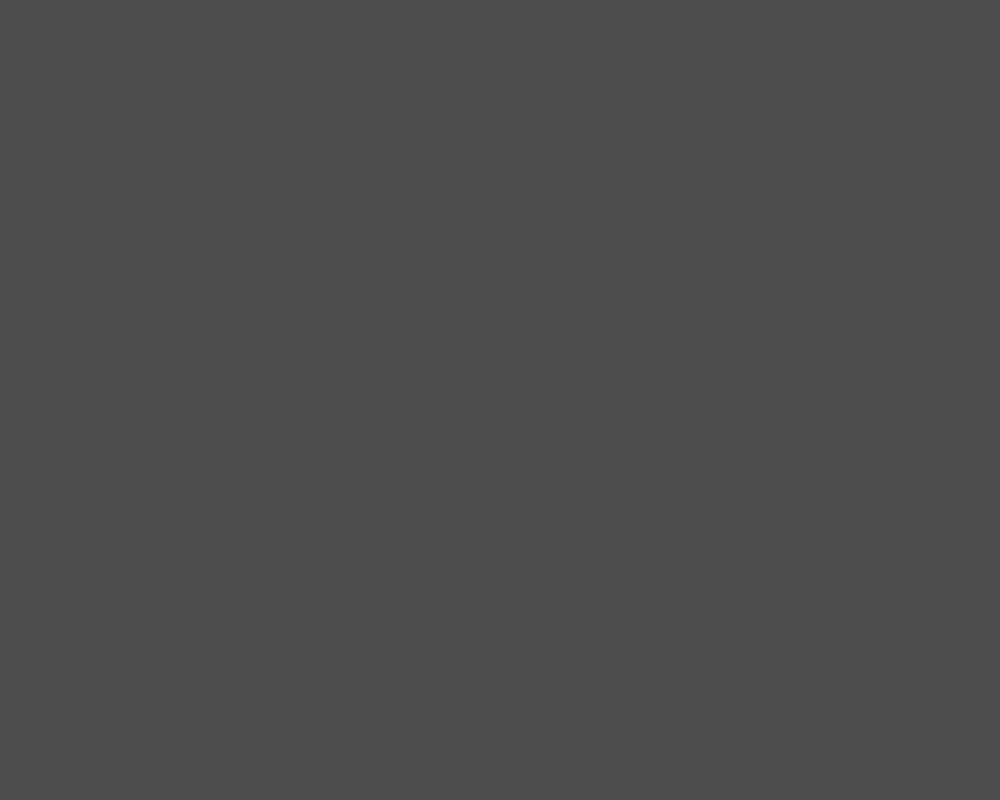

In [4]:
#file_name = 'input_files/honeycomb.inp'
output_file = 'input_files/honeycomb.k'
toolpath_file = 'input_files/toolpath_honeycomb.crs'
height = 15
radius = 1
path_resolution = 0.1
#write_keywords(file_name,output_file,height)
write_birth(output_file,toolpath_file,path_resolution,radius,gif_end=200,nFrame=100)
write_parameters(output_file)

In [7]:
domain = domain_mgr(filename='input_files/honeycomb.k',toolpath_file='input_files/toolpath_honeycomb.crs')

Time of reading input files: 0.7568995952606201
Time of calculating critical timestep: 0.31267261505126953
Time of reading and interpolating toolpath: 0.15796327590942383
Number of nodes: 63484
Number of elements: 48505
Number of time-steps: 215953
Time of generating surface: 52.189576625823975


In [11]:
%%time
Ki = 50
Kp = 100
Kd = 0

heat_solver = heat_solve_mgr(domain)
melt_data = []
domain.current_time = 0
endtime = 2000
timestep = int(endtime/domain.dt)+1

control_step = 17
control_track = 0
melt_depth_control = 0
err_n = 0
err_n_1 = 0
err_n_2 = 0
control_data = []
for t in range(1,timestep):
    melt_depth_desired = 1.75
    heat_solver.time_integration()
    heat_solver.calculate_melt()
    if t % 5000 == 0:
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
        print("Current time:  {}, Percentage done:  {}%".format(domain.current_time,100*t/timestep))


#    data.append(np.array(heat_solver.temperature.get()))
    melt_data.append([domain.current_time,heat_solver.melt_depth,heat_solver.q_in,heat_solver.laser_state])
    control_data.append([control_track,err_n,err_n_1,melt_depth_control])
    if domain.current_time>200:
        if heat_solver.laser_state>0:
            control_track += 1
            melt_depth_control += heat_solver.melt_depth/control_step
            if control_track == control_step:
                control_track = 0
                if heat_solver.laser_loc[1]>0:
                    melt_depth_desired = 1.25
                err_n = melt_depth_desired - melt_depth_control 
                heat_solver.q_in = heat_solver.q_in + Kp * (err_n - err_n_1) + Ki * err_n + Kd * (err_n + err_n_2 - 2*err_n_1)
                heat_solver.q_in = cp.clip(heat_solver.q_in,100,500)
                err_n_2 = err_n_1
                err_n_1 = err_n
                melt_depth_control = 0

        if heat_solver.laser_state==0:
            control_track = 0
            err_n = 0
            err_n_1 = 0
            err_n_2 = 0

melt_data=np.array(melt_data)
control_data = np.array(control_data)
data1 = np.concatenate((melt_data,control_data),axis=1)
np.save('half_kp{}ki{}_kd{}'.format(Kp,Ki,Kd),data1)

Current time:  46.30649172550715, Percentage done:  2.315318610994059%
Current time:  92.6129834509948, Percentage done:  4.630637221988118%
Current time:  138.91947517648563, Percentage done:  6.945955832982177%
Current time:  185.22596690203076, Percentage done:  9.261274443976236%
Current time:  231.5324586275759, Percentage done:  11.576593054970294%
Current time:  277.838950353121, Percentage done:  13.891911665964354%
Current time:  324.1454420786661, Percentage done:  16.207230276958413%
Current time:  370.45193380421125, Percentage done:  18.52254888795247%
Current time:  416.7584255297564, Percentage done:  20.83786749894653%
Current time:  463.0649172553015, Percentage done:  23.153186109940588%
Current time:  509.37140898084664, Percentage done:  25.468504720934646%
Current time:  555.6779007063917, Percentage done:  27.78382333192871%
Current time:  601.9843924319368, Percentage done:  30.099141942922767%
Current time:  648.290884157482, Percentage done:  32.414460553916825

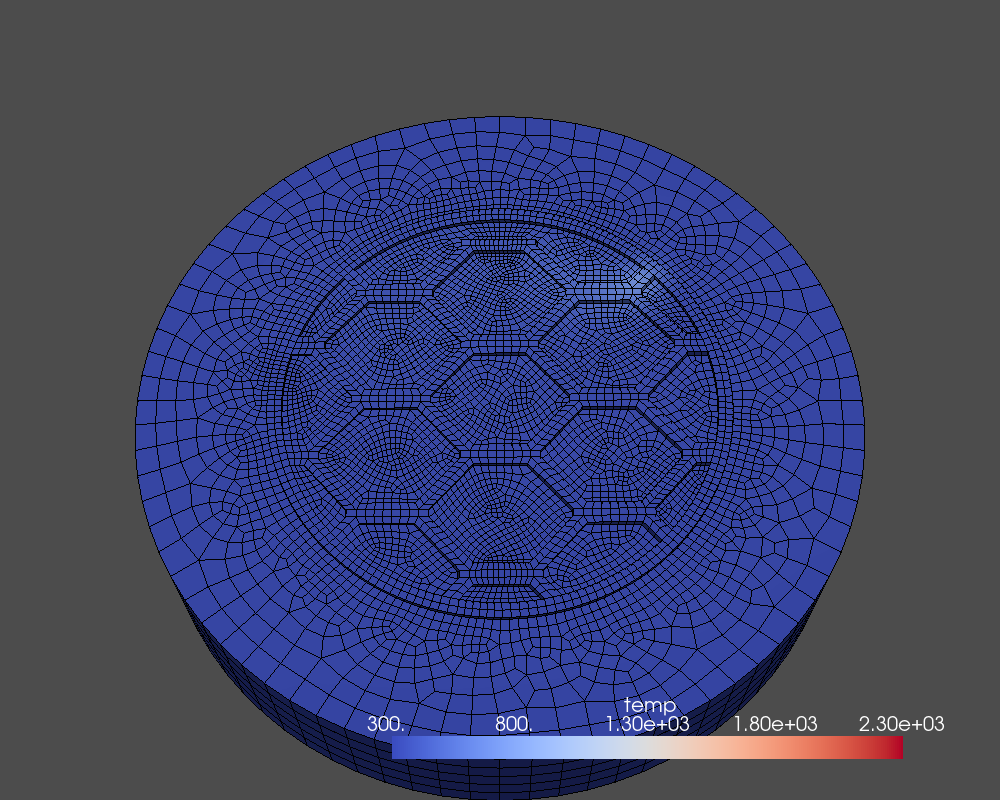

[(0.0, -100.0, 180.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [7]:
for t in range(1,10):
    heat_solver.time_integration()
    heat_solver.calculate_melt()
    if t % 500 == 0:
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
#    data.append(np.array(heat_solver.temperature.get()))
    data.append(heat_solver.melt_depth)

import pyvista as pv
from pyvirtualdisplay import Display
import vtk
display = Display(visible=0)
_ = display.start()
active_elements = domain.elements[domain.active_elements].tolist()
active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
points = domain.nodes.get()
active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
active_grid.point_arrays['temp'] = heat_solver.temperature.get()
p = pv.Plotter(window_size=(1000,800))
p.camera_position = ((0, -100, 180),(0, 0, 0),(0.0, 0.0, 1.0))
p.add_mesh(active_grid, show_edges=True, scalars='temp',cmap="coolwarm",clim=[300,2300])
p.show()

<IPython.core.display.Javascript object>


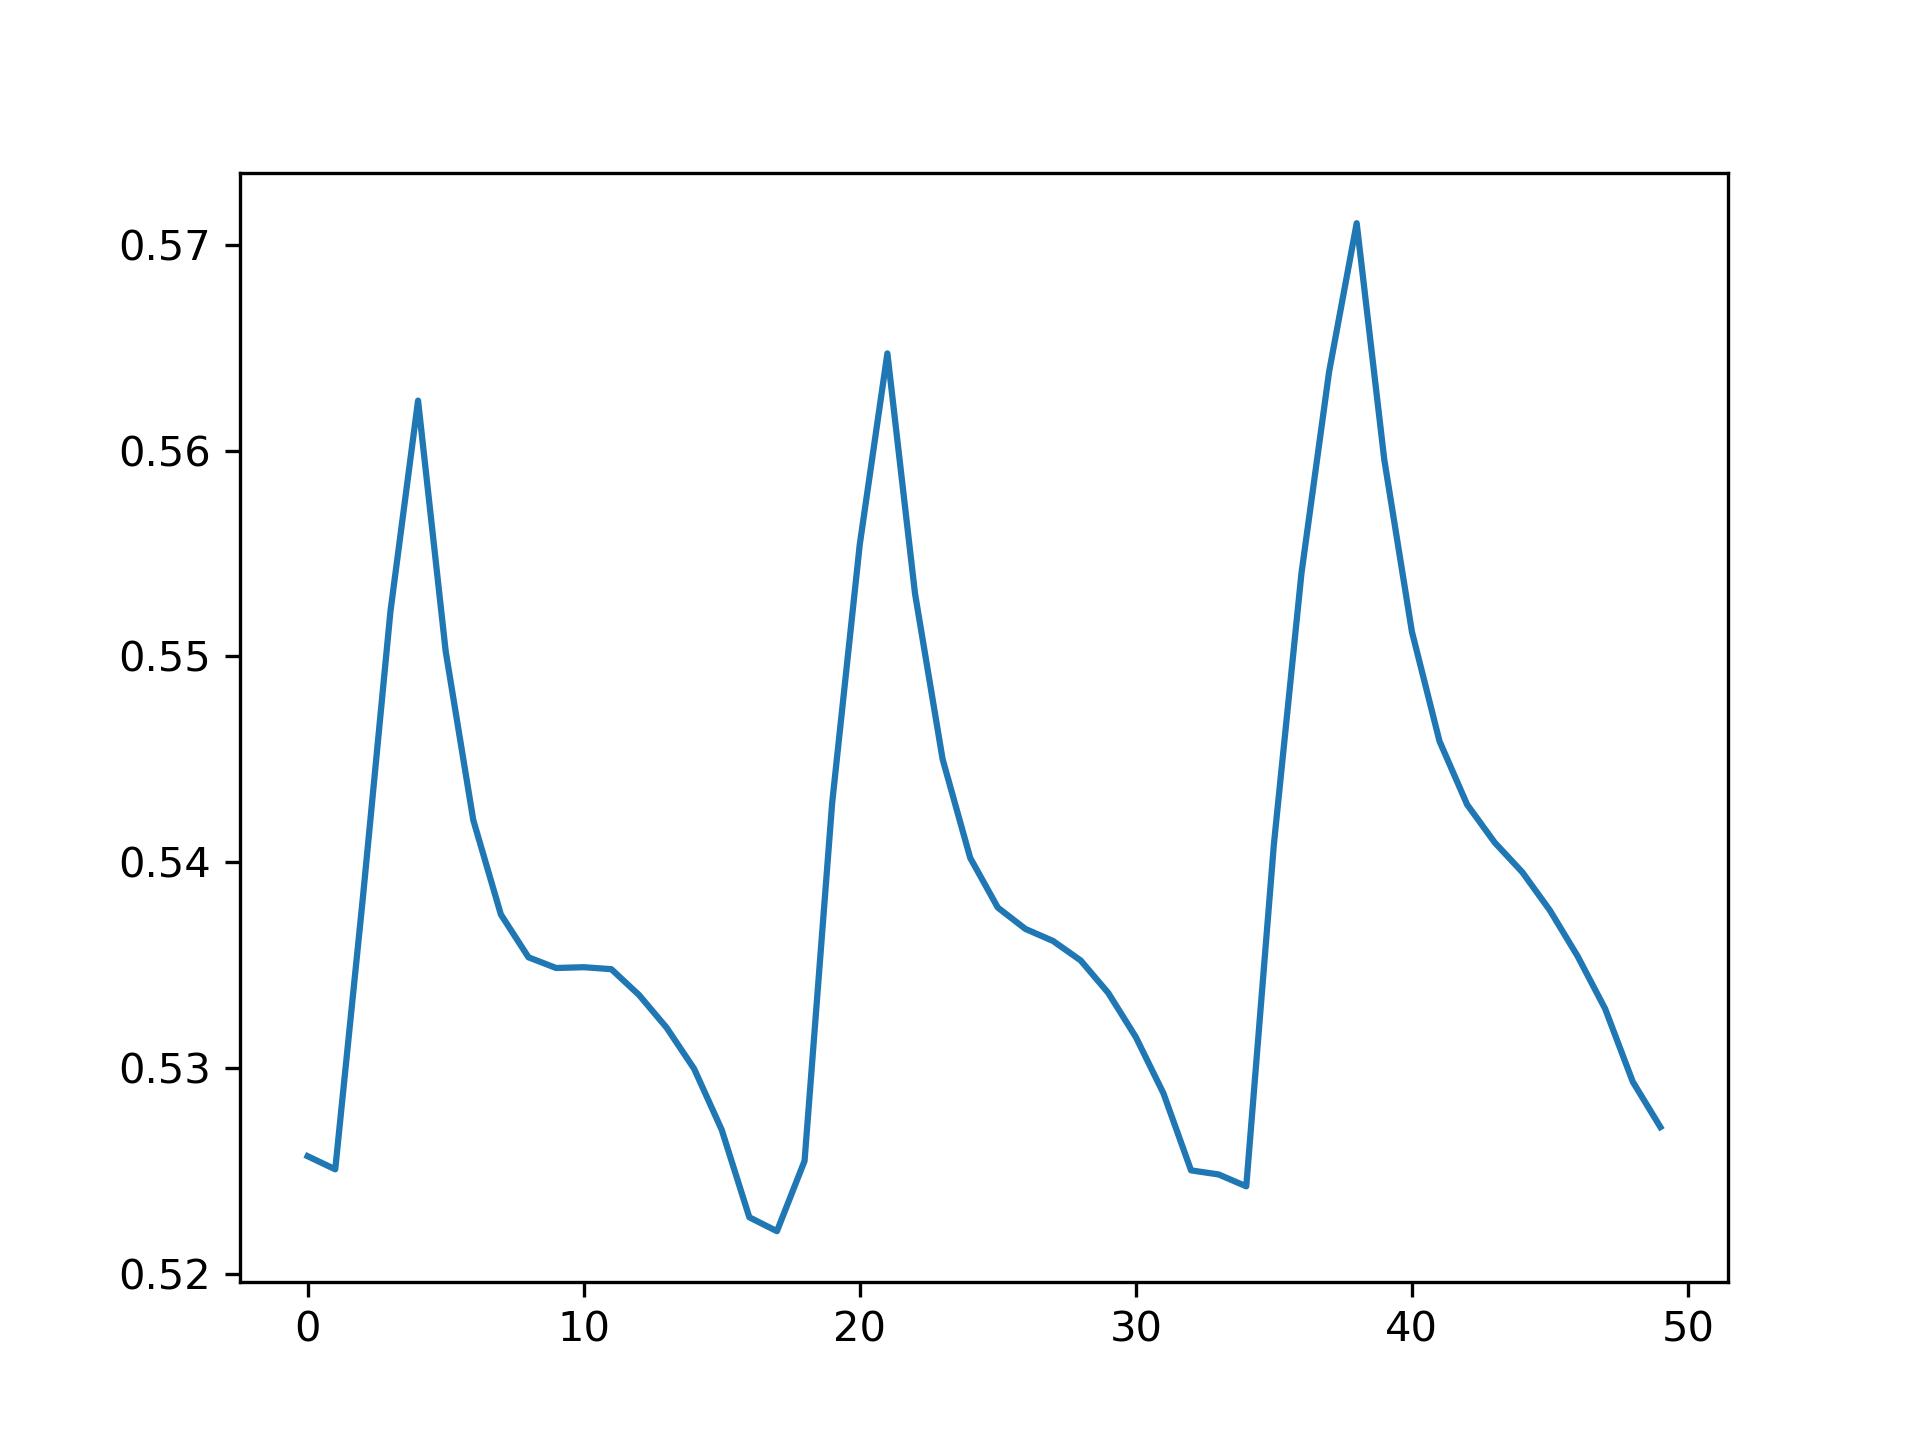

In [11]:
data = np.array(data)
data.astype(dtype=np.float32)
plt.plot(data[500:550])

<IPython.core.display.Javascript object>


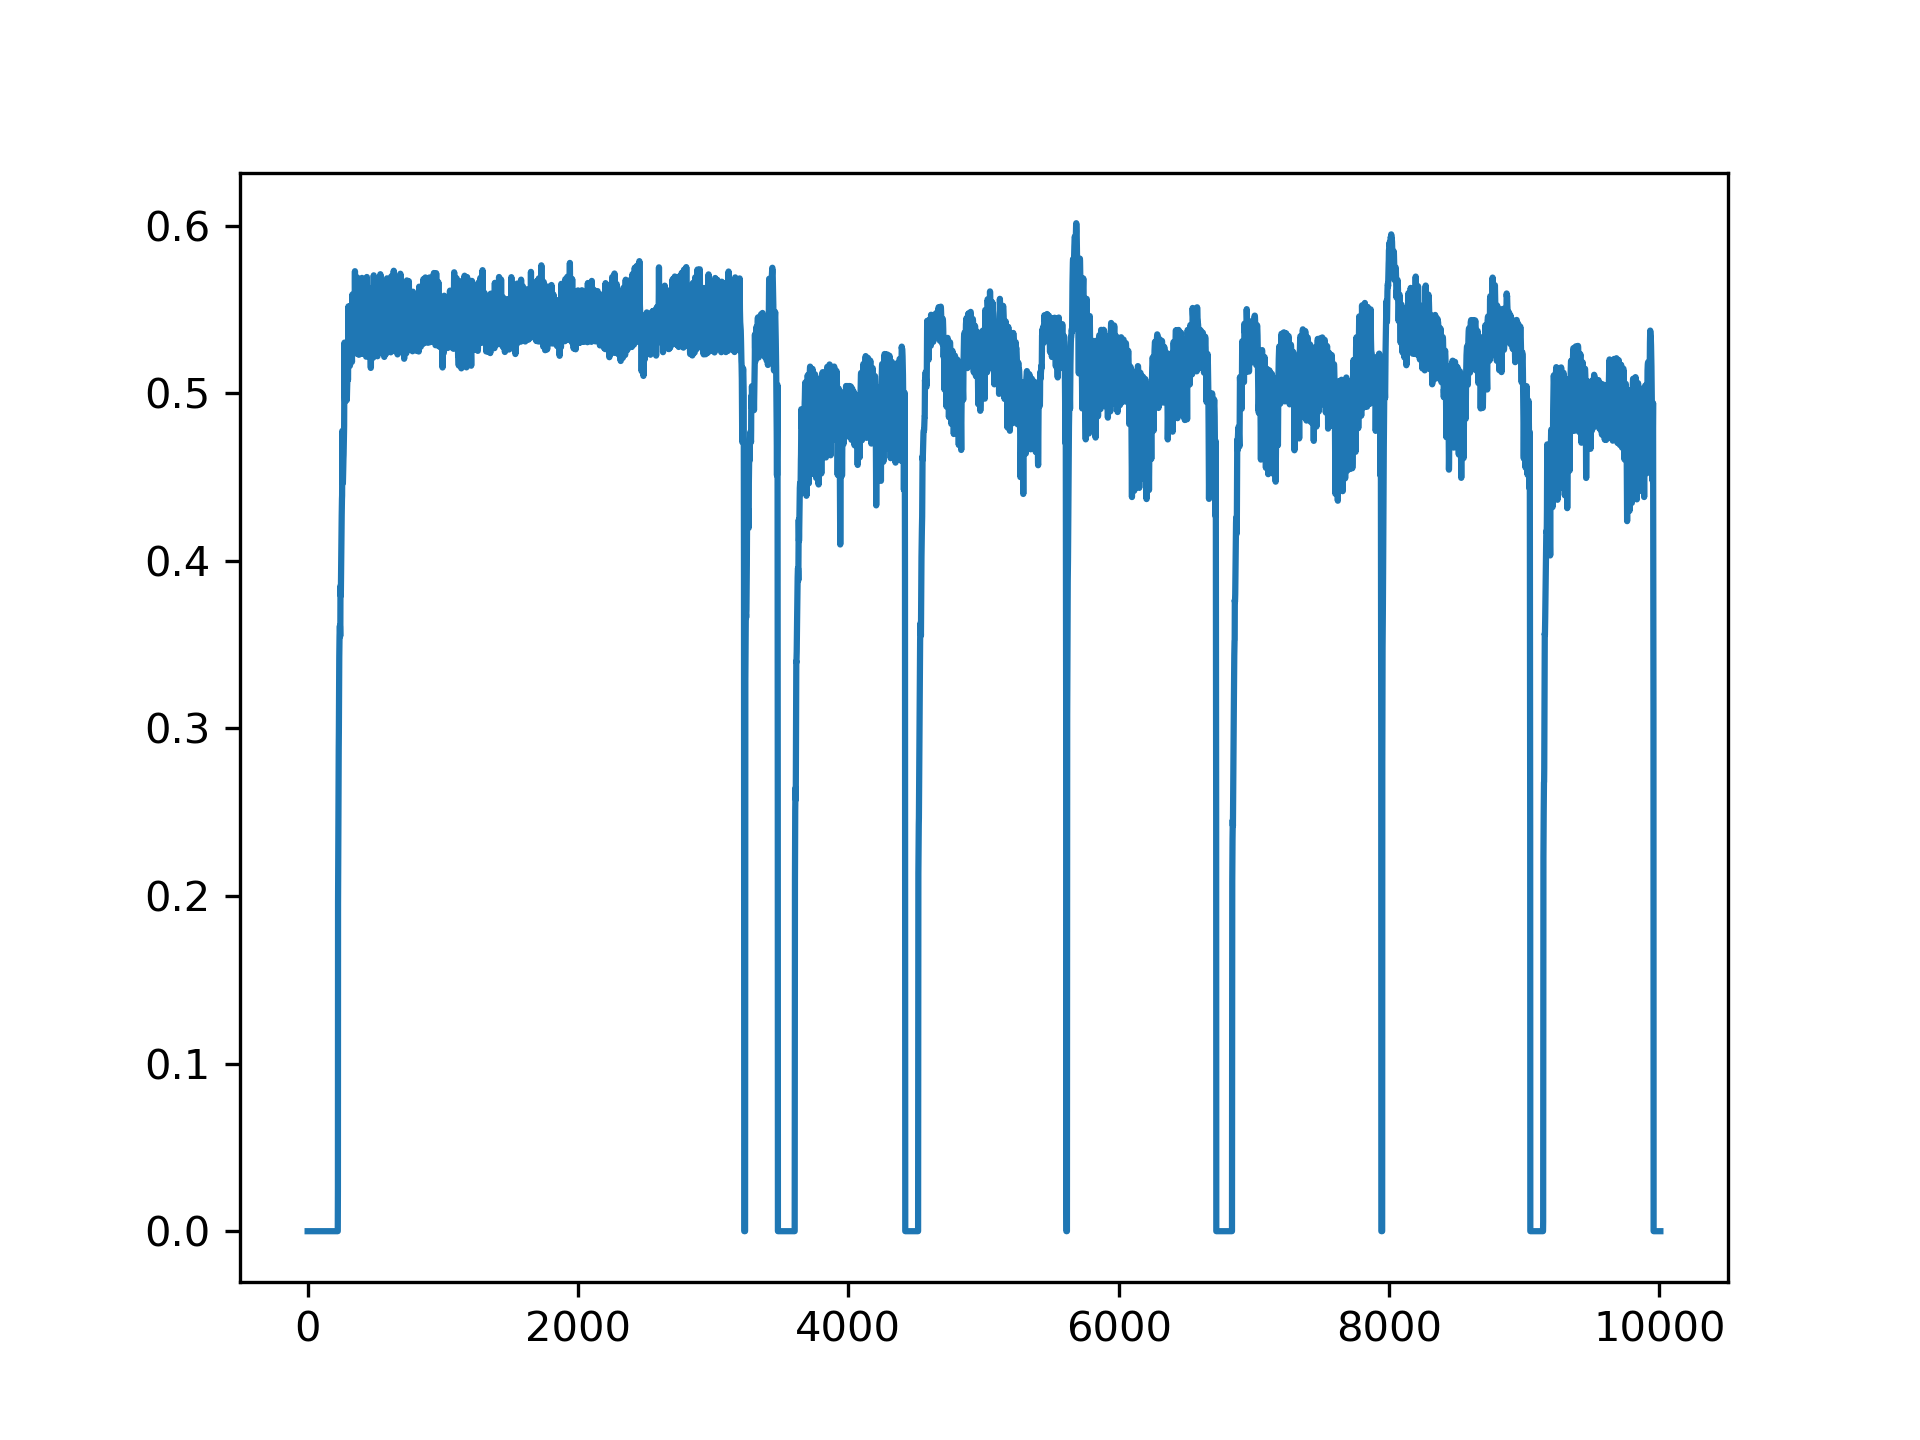

In [15]:
data = np.array(data)
data.astype(dtype=np.float32)
plt.plot(data)

<IPython.core.display.Javascript object>


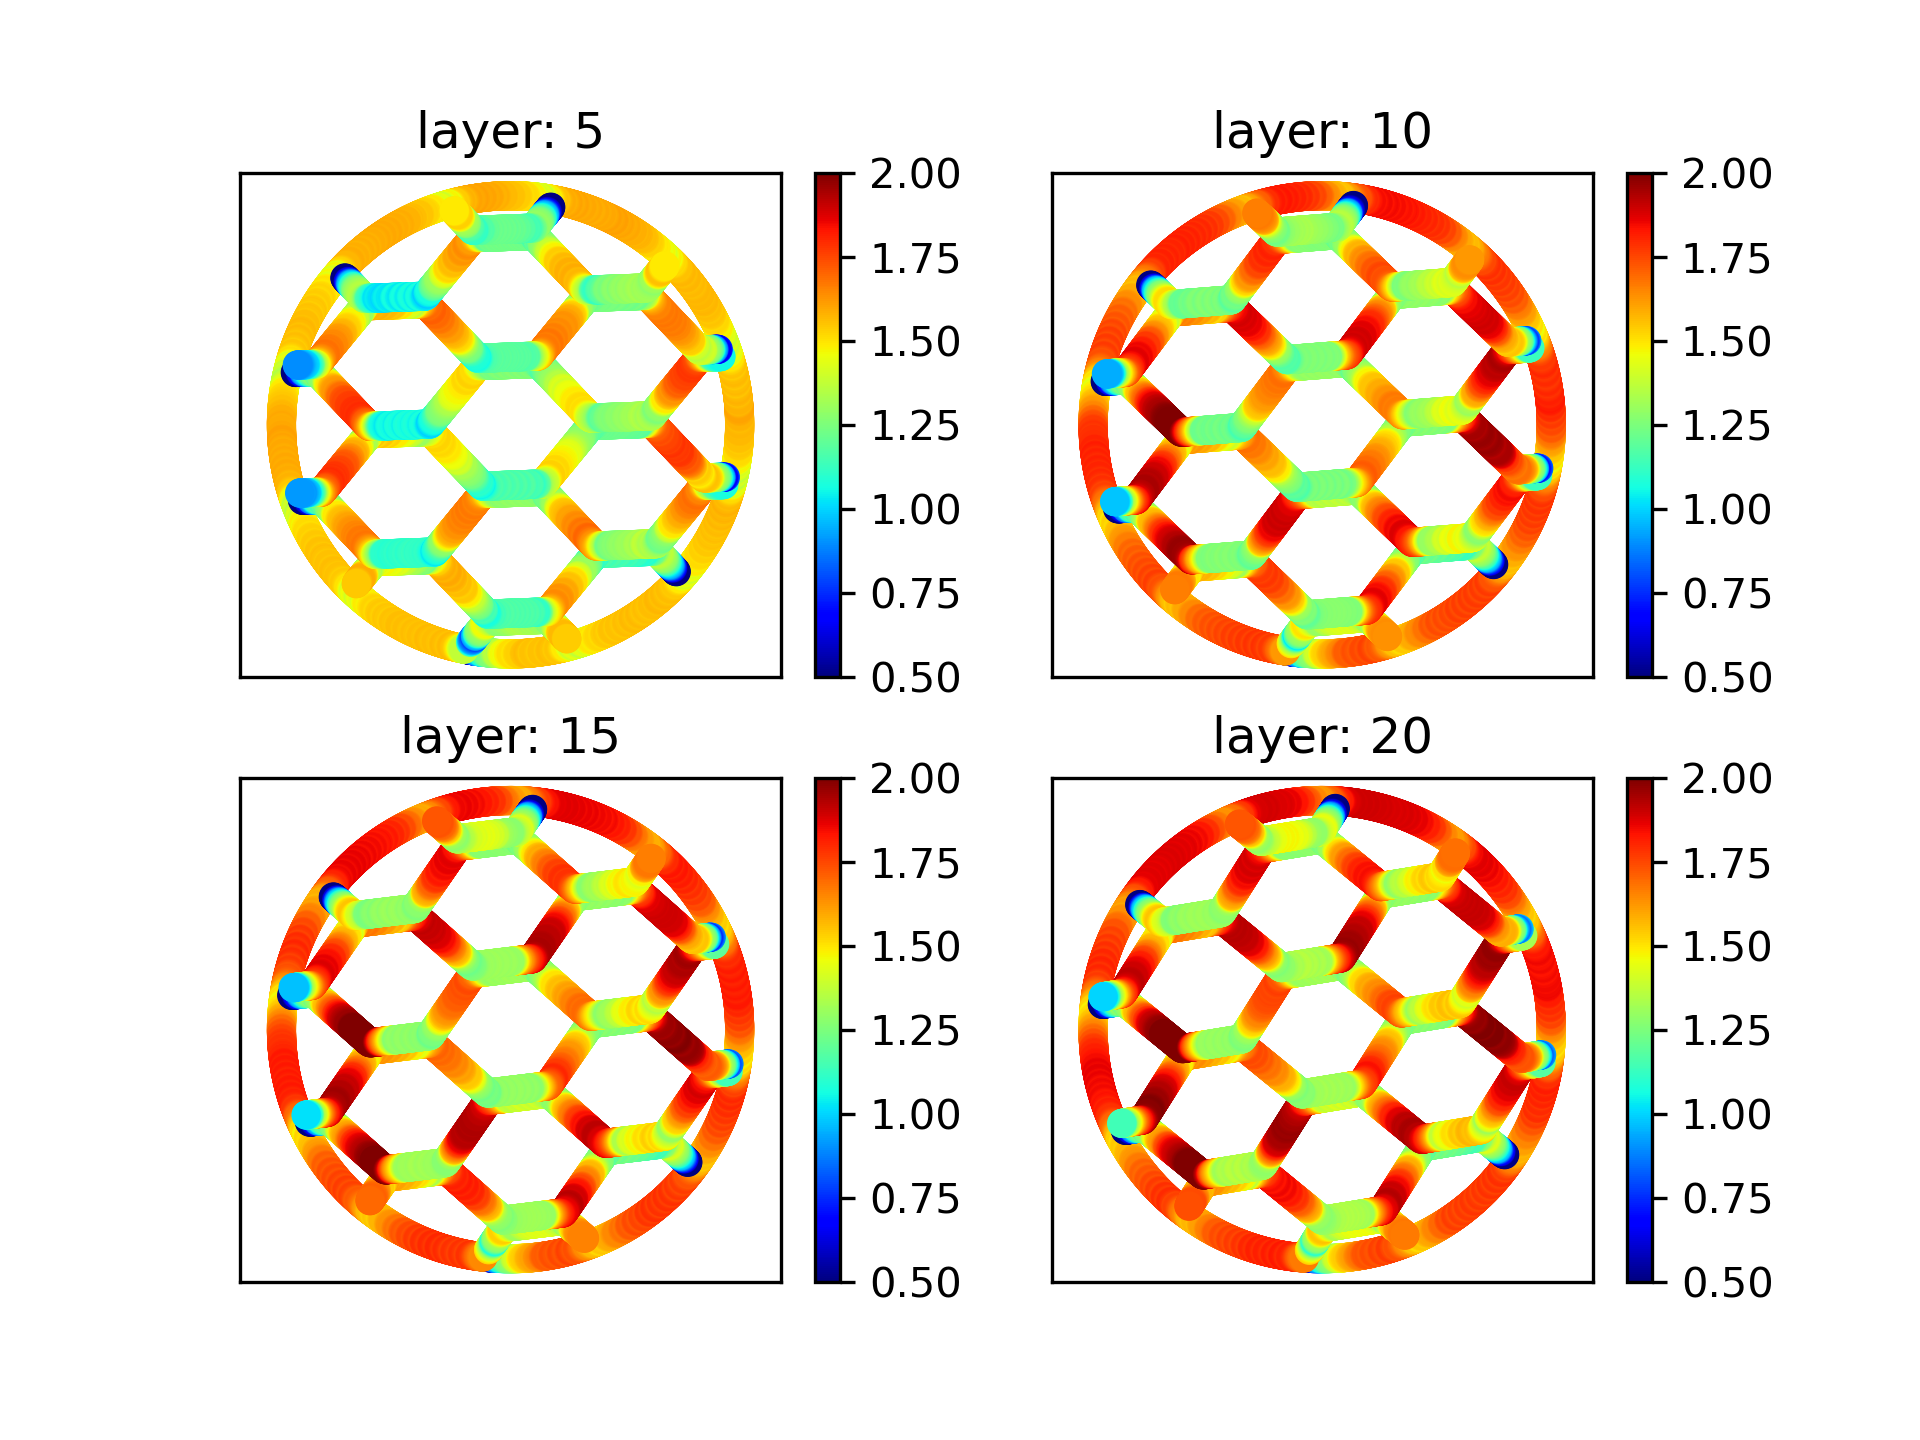

In [31]:
data = np.load('half_kp0ki0_kd0.npy',allow_pickle=True)
t = data[:,0]
melt = data[:,1]

toolpath_raw = load_toolpath(filename = 'input_files/toolpath_honeycomb.crs')
pos = get_toolpath(toolpath_raw,t[0],t[-1])
pos = pos[1:pos.shape[0]+1]

i=1
for layer in range(5,21,5):

    melt_current = melt[pos[:,3]==1]
    pos_current = pos[pos[:,3]==1]
    melt_current = melt_current[(abs(pos_current[:,2]-0.66*layer)<1e-5)]
    pos_current = pos_current[(abs(pos_current[:,2]-0.66*layer)<1e-5),0:3]
    plt.subplot(2,2,i)
    plt.scatter(pos_current[:,0],pos_current[:,1],c=melt_current,cmap='jet',vmin=0.5,vmax=2)
    plt.axis('equal')
    plt.colorbar()
    plt.show()
    plt.title('layer: {}'.format(layer))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    i+=1


<IPython.core.display.Javascript object>


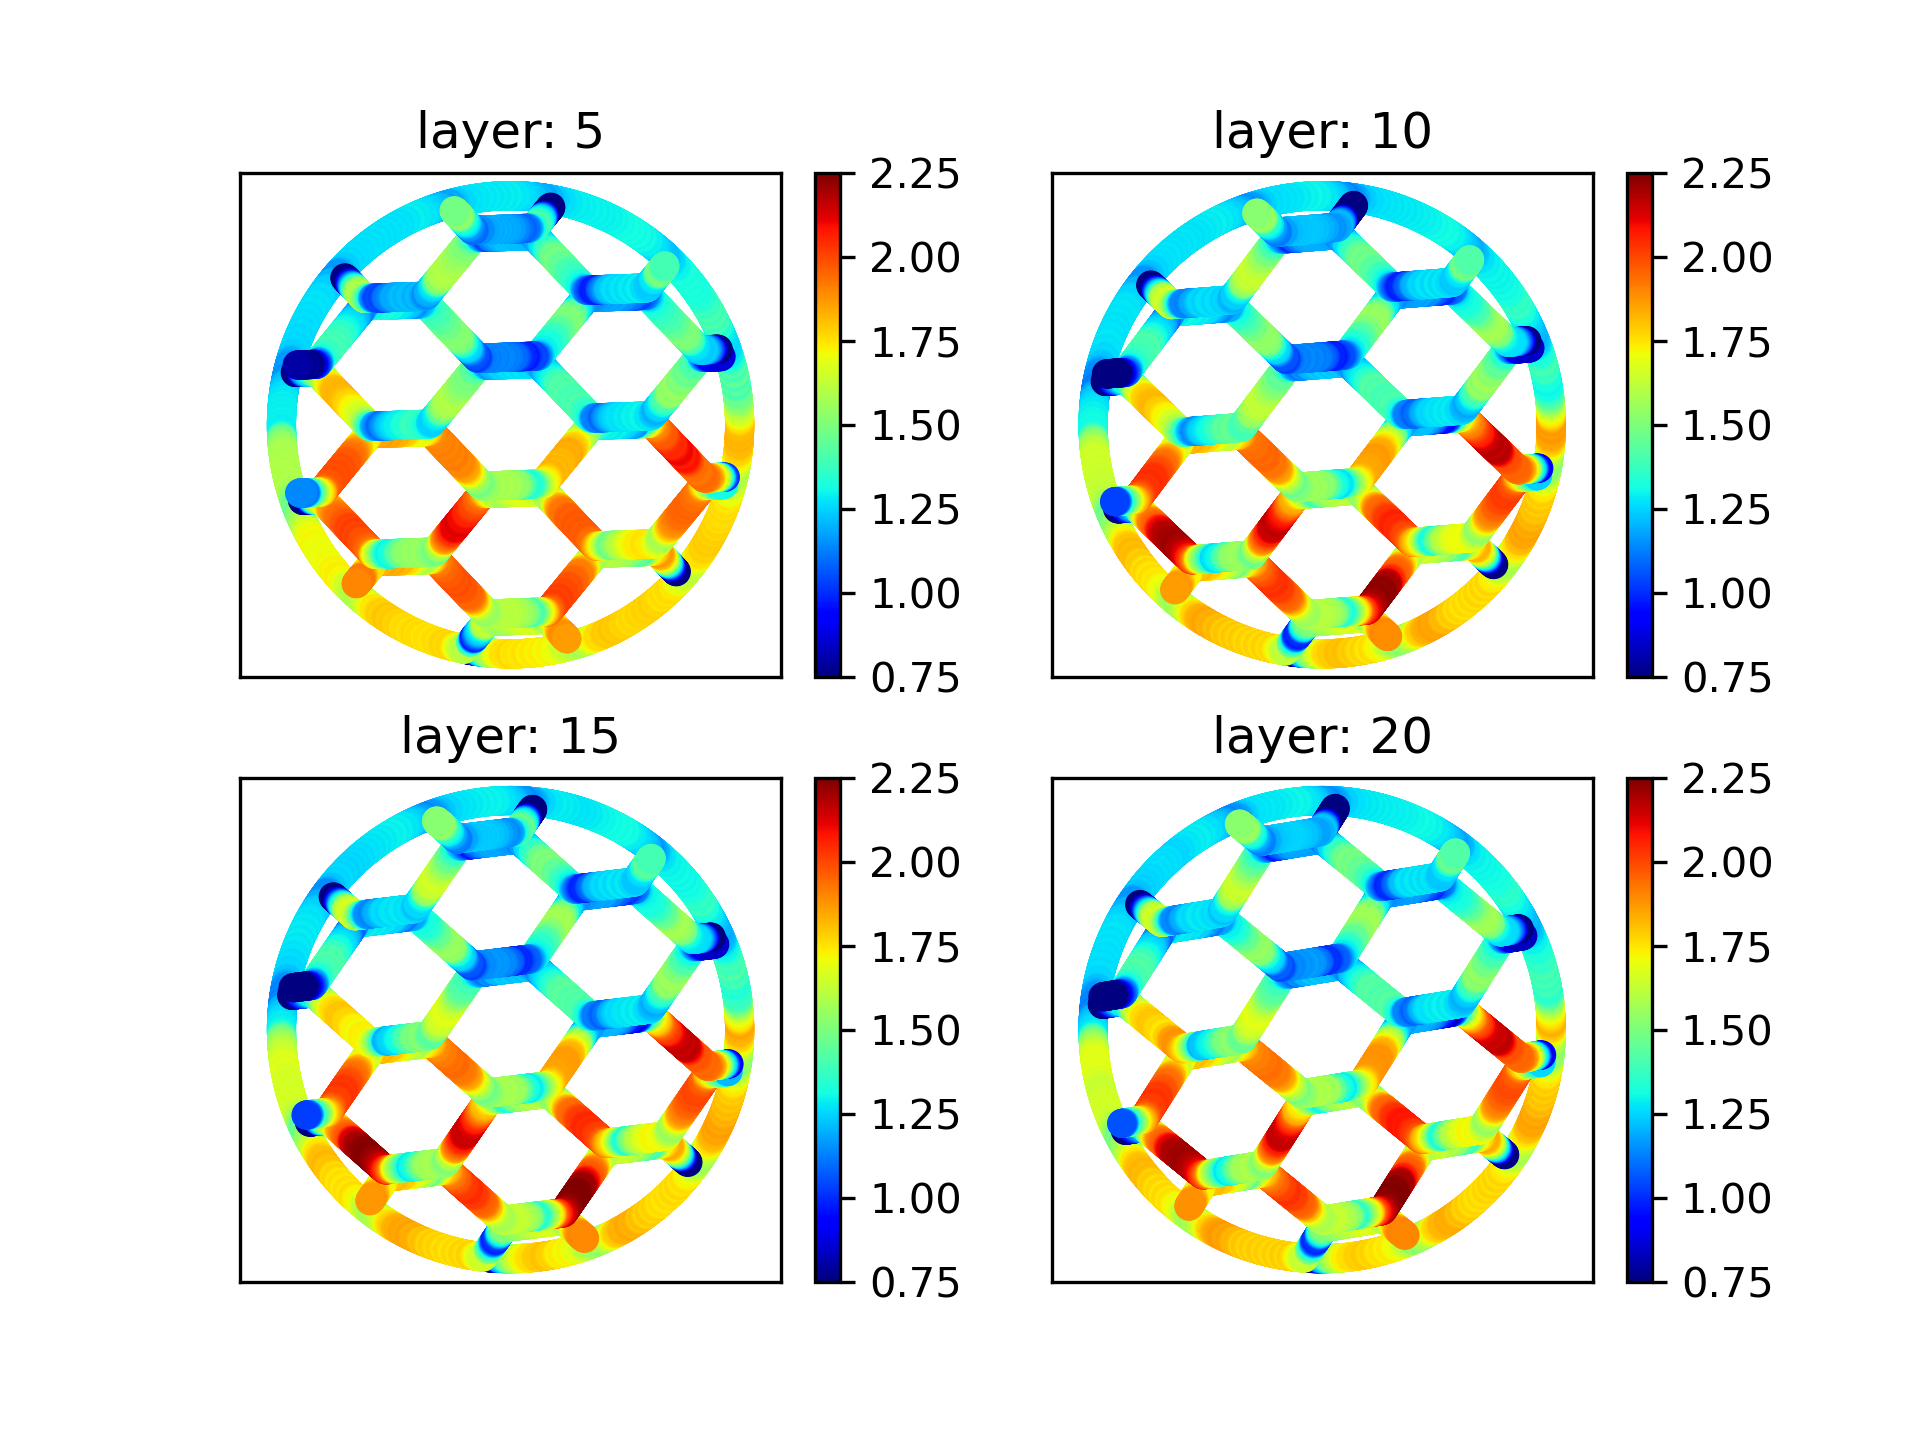

In [47]:
data = np.load('half_kp100ki20_kd0.npy',allow_pickle=True)
t = data[:,0]
melt = data[:,1]

toolpath_raw = load_toolpath(filename = 'input_files/toolpath_honeycomb.crs')
pos = get_toolpath(toolpath_raw,t[0],t[-1])
pos = pos[1:pos.shape[0]+1]

i=1
for layer in range(5,21,5):

    melt_current = melt[pos[:,3]==1]
    pos_current = pos[pos[:,3]==1]
    melt_current = melt_current[(abs(pos_current[:,2]-0.66*layer)<1e-5)]
    pos_current = pos_current[(abs(pos_current[:,2]-0.66*layer)<1e-5),0:3]
    plt.subplot(2,2,i)
    plt.scatter(pos_current[:,0],pos_current[:,1],c=melt_current,cmap='jet',vmin=0.75,vmax=2.25)
    plt.axis('equal')
    plt.colorbar()
    plt.show()
    plt.title('layer: {}'.format(layer))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    i+=1


<IPython.core.display.Javascript object>


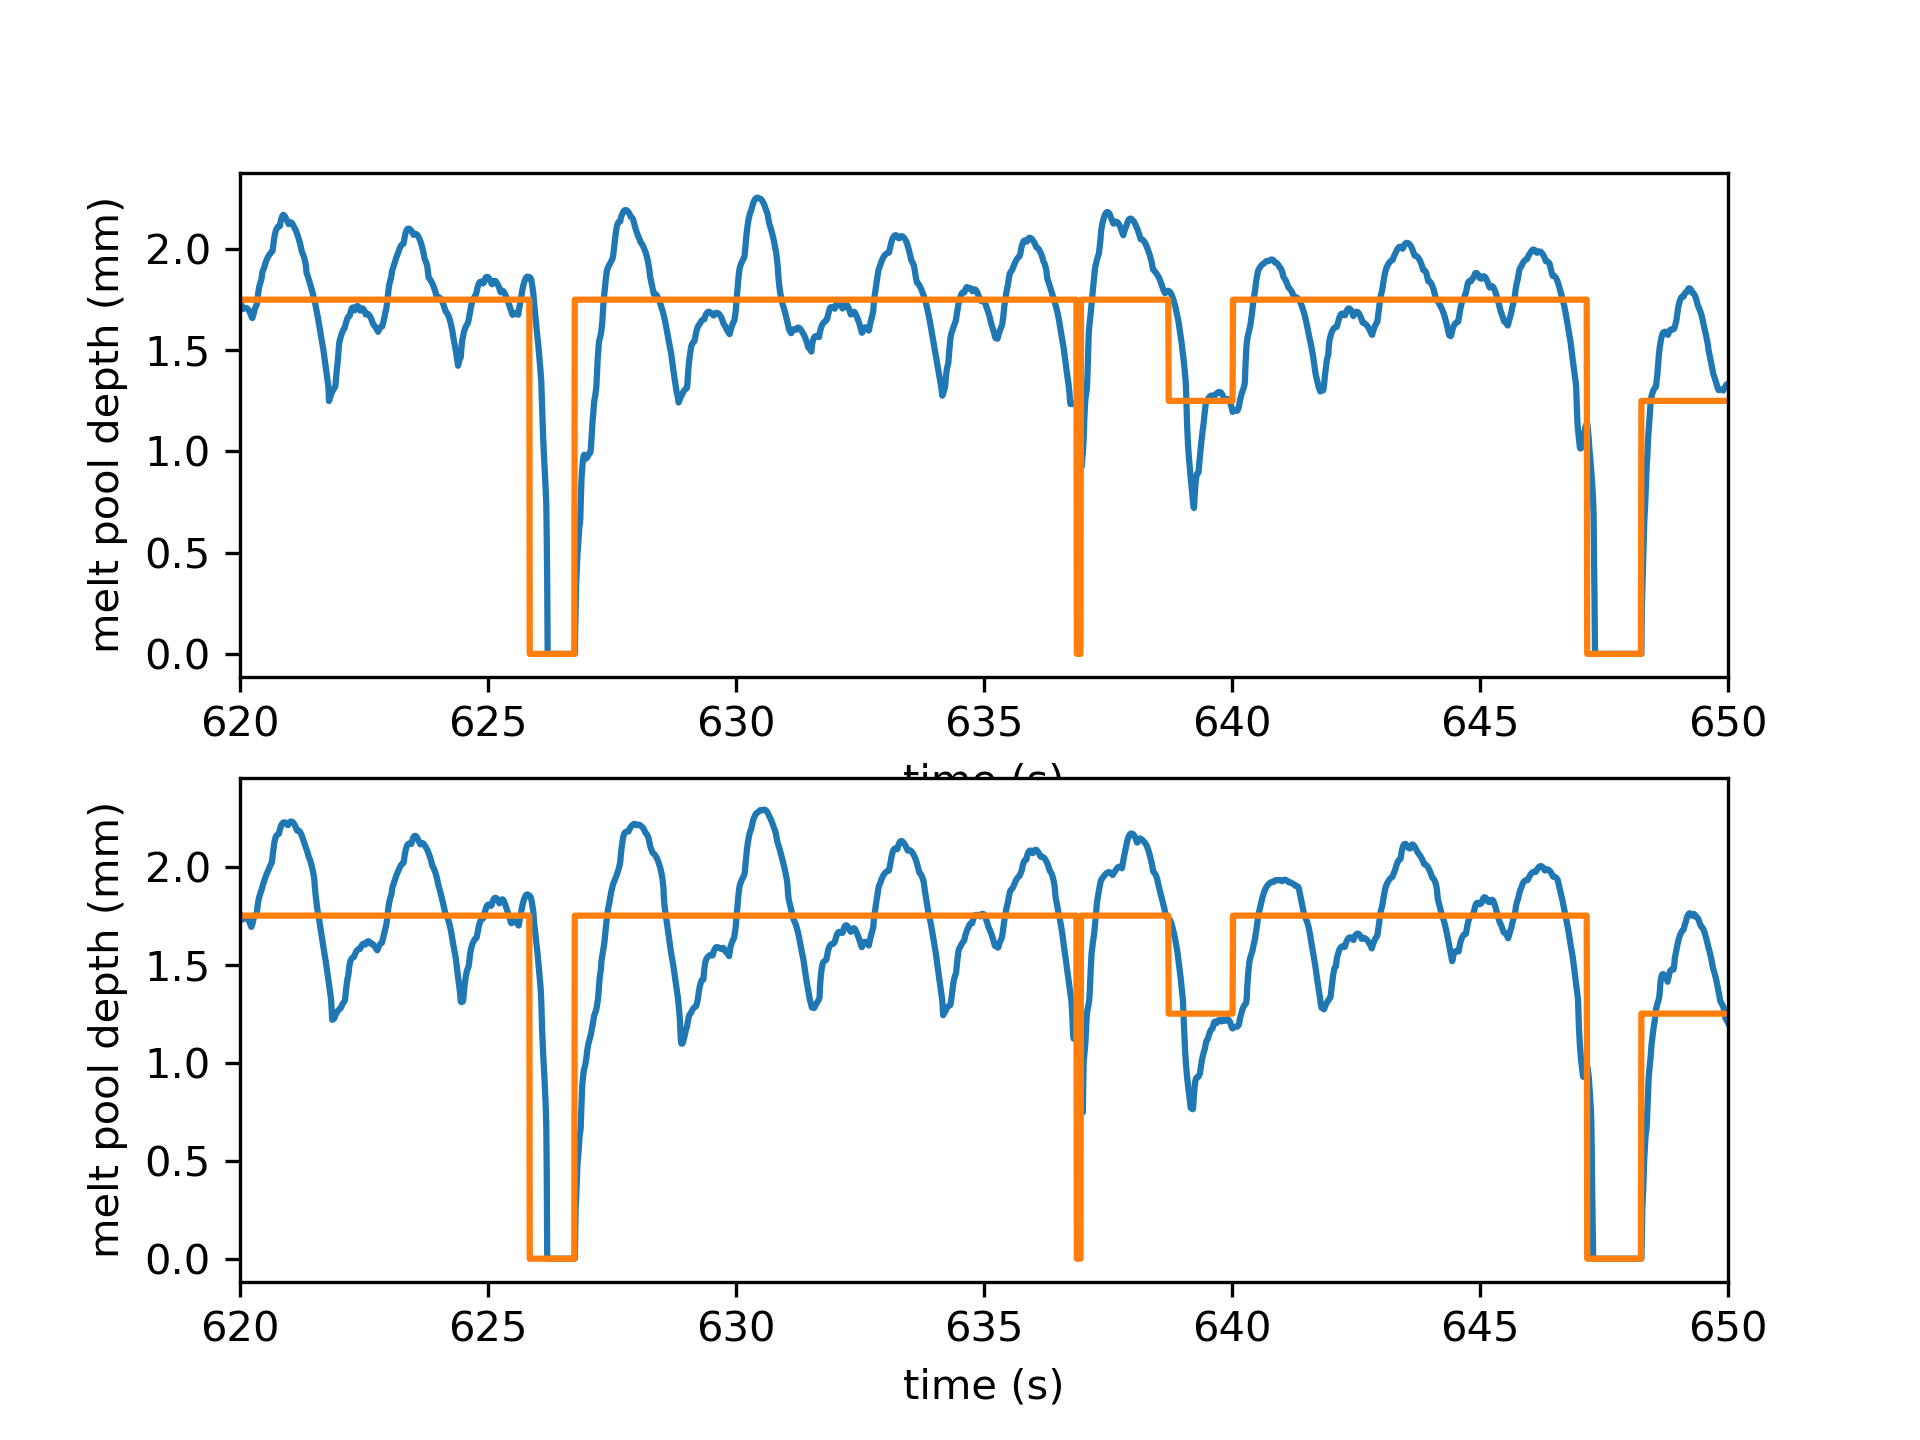

In [17]:
plt.subplot(2,1,1)
data = np.load('half_kp200ki50_kd0.npy',allow_pickle=True)
t = data[:,0]
melt = data[:,1]
plt.plot(t,melt)
toolpath_raw = load_toolpath(filename = 'input_files/toolpath_honeycomb.crs')
pos = get_toolpath(toolpath_raw,t[0],t[-1])
pos = pos[1:pos.shape[0]+1,:]
melt_desired = 1.75*np.ones_like(t)
melt_desired[pos[:,1]>0] = 1.25
melt_desired[pos[:,3]==0] = 0
plt.plot(t,melt_desired)
plt.xlabel('time (s)')
plt.ylabel('melt pool depth (mm)')
plt.xlim(620,650)
plt.show()



plt.subplot(2,1,2)
data = np.load('half_kp100ki50_kd0.npy',allow_pickle=True)
t = data[:,0]
melt = data[:,1]
plt.plot(t,melt)
pos = get_toolpath(toolpath_raw,t[0],t[-1])
pos = pos[1:pos.shape[0]+1,:]
melt_desired = 1.75*np.ones_like(t)
melt_desired[pos[:,1]>0] = 1.25
melt_desired[pos[:,3]==0] = 0
plt.plot(t,melt_desired)
plt.xlabel('time (s)')
plt.ylabel('melt pool depth (mm)')
plt.xlim(620,650)
plt.show()
